# Applied Machine Learning: In-class Exercise 01-3

## Goal

In this exercise, we go beyond resampling single learners and explore how to benchmark multiple models efficiently. Instead of tuning hyperparameters, we compare identical models with manually set hyperparameters. Our focus is on systematically evaluating model performance using benchmarking techniques in scikit-learn.

## German Credit Data

For this benchmarking task, we use the German Credit Data dataset from OpenML.

In [1]:
import numpy as np
import pandas as pd
import warnings

from sklearn.datasets import fetch_openml

warnings.filterwarnings("ignore")


# Set seed for reproducibility
rng = np.random.RandomState(seed=2025)

# Load the German Credit Data from OpenML.
data = fetch_openml(name='credit-g', version=1, as_frame=True)
X = data.data

# Record which columns are continuous, this will be useful later.
continuous_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Here we assume that "good" is the positive class and we encode it to 1. 
# Therefore, "bad" is the negative class and is encoded to 0.
y = data.target == 'good'

# One-hot encode categorical features.
X = pd.get_dummies(X, drop_first=True)

## Exercise: Benchmark Multiple Learners

In this exercise, we compare a range of K-Nearest Neighbors (KNN) models with different values of k, ranging from 3 to 30. Additionally, we evaluate the performance of Logistic Regression as a baseline model.

## Create the Learners

We define a Logistic Regression model and multiple KNN models with k-values from 3 to 30. Each KNN model is assigned an ID that reflects its k value. All learners are stored in a list for benchmarking.

<details>
<summary>Hint 1:</summary>
Use list comprehension to create a list of tuples, where each tuple contains a learner ID and a learner object. Similarily, create a single tuple for the Logistic Regression model.
Then, you can concatenate the two lists to create a list of all learners.
</details>

<details>
<summary>Hint 2:</summary>
Better wrap the creation of the learners in a function, so that we can reuse it later (in the last part of this exercise).
</details>

In [2]:
#===SOLUTION===
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

def create_learners():
    # Create a dictionary to store learners
    learners = {}
    
    # Logistic Regression
    learners['classif.log_reg'] = LogisticRegression(max_iter=1000)
    
    # KNN learners with k from 3 to 30
    for k in range(3, 31):
        learners[f'classif.knn{k}'] = KNeighborsClassifier(n_neighbors=k)
    
    return learners

learners = create_learners()

## Create a Benchmarking Design
To set up our benchmarking experiment, we define a task (German Credit Data), multiple learners (Logistic Regression and KNN models with k-values from 3 to 30), and a resampling technique (4-fold cross-validation).

<details>
<summary>Hint 1:</summary>
Use the `StratifiedKFold` class from scikit-learn to create a 4-fold cross-validation splitter.
</details>

In [3]:
#===SOLUTION===

from sklearn.model_selection import StratifiedKFold

# Create a 4-fold cross-validation splitter.
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=2025)

## Define a custom scorer for false positive rate (FPR).
In case of a credit use case the false positive rate (FPR) may be innteresting to study next to the accuracy. However, unlike mlr3, sklearn's learners are not inherently equiped with FPR. So, we need to manually define it. 

<details>
<summary>Hint 1:</summary>
Define a custom scorer for FPR with 1 as the positive class. The FPR is calculated as the ratio of false positive (FP) to the sum of true negative (TN) and false positives (FP). The FPR is then multiplied by 100 to get a percentage value.
</details>

<details>
<summary>Hint 2:</summary>
Use `sklearn.metrics.confusion_matrix` to compute the FP and TN, and use `sklearn.metrics.make_scorer` function to create a scorer object for the FPR. Set the `greater_is_better` argument to `False` because we want to minimize the FPR.
</details>

In [4]:
#===SOLUTION===

from sklearn.metrics import make_scorer, confusion_matrix

# Define a custom scorer for false positive rate (FPR) with 1 as the positive class.
def false_positive_rate_percent(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Use confusion_matrix to compute TN and FP
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    # For binary classification with 1 as positive class:
    # cm[1,1] = TN (true negatives)
    # cm[1,0] = FP (false positives)
    
    TN = cm[1, 1]
    FP = cm[1, 0]
    
    if TN + FP == 0:
        return 0.0
    
    return (FP / (TN + FP)) * 100

# The lower FPR, the better
fpr_scorer = make_scorer(false_positive_rate_percent, greater_is_better=False)

## Run the benchmark



<details>
<summary>Hint 1:</summary>
Use the `cross_validate` function from scikit-learn to evaluate each learner using 4-fold cross-validation. Store the fold-wise accuracy scores for the boxplot.
</details>

<details>
<summary>Hint 2:</summary>
Calculate the mean accuracy and false negative rate for each learner. In addition, check the docs of "greater_is_better" argument of `make_scorer()`. Based on this documentation, what adaptation do you need to make to the code?
</details>

Note, when using `sklearn.model_selection.cross_validate`, we use the argument `n_jobs=None` by default, this means that we haven't enabled the parallelism in `sklearn`. Therefore, it might take some while. You can also try different values of `n_jobs` and see how much speedup you can get on your computer.

## Solution:

In [5]:
#===SOLUTION===

from sklearn.model_selection import cross_validate

# Benchmarking: evaluate each learner using cross-validation.
# We will store the fold-wise accuracy scores for the boxplot.
accuracy_scores = {}
results = []

# Note: we benchmark the models sequentially, so the simple for-loop might reduce the speed
# In contrast, the benchmark is fully parallelized in mlr3. 
for learner_id, model in learners.items():
    cv_results = cross_validate(model, X, y, cv=cv,
                                scoring={'accuracy': 'accuracy', 'fpr': fpr_scorer})
    # Store all fold accuracy scores for the boxplot.
    accuracy_scores[learner_id] = cv_results['test_accuracy']

    acc_mean = np.mean(cv_results['test_accuracy'])
    fpr_mean = np.mean(cv_results['test_fpr'])
    # According to the docs of "greater_is_better" argument of `make_scorer()`,
    # "greater_is_betterbool, default=True. Whether score_func is a score function (default), 
    #  meaning high is good, or a loss function, meaning low is good. In the latter case, 
    #  the scorer object will sign-flip the outcome of the score_func."

    # Hence, we need to re-flip the sign of `fpr_mean`.
    
    results.append({'learner_id': learner_id,
                    'classif.acc': acc_mean,
                    'classif.fpr': - fpr_mean})

results_df = pd.DataFrame(results)
print(results_df.head())

        learner_id  classif.acc  classif.fpr
0  classif.log_reg        0.760    51.333333
1     classif.knn3        0.643    72.666667
2     classif.knn4        0.610    56.666667
3     classif.knn5        0.667    74.666667
4     classif.knn6        0.652    65.000000


## Boxplot the benchmark results

To gain a comprehensive understanding of the model's performance, it's important not only to look at the average accuracy across the $k$-folds, but also to examine the variability in performance across the different folds. This helps assess the model's stability. In this case, a boxplot is a useful tool.

<details>
<summary>Hint 1:</summary>
Use the `matplotlib.pyplot.boxplot` to create a boxplot of the accuracy scores for each learner.
</details>

Solution:

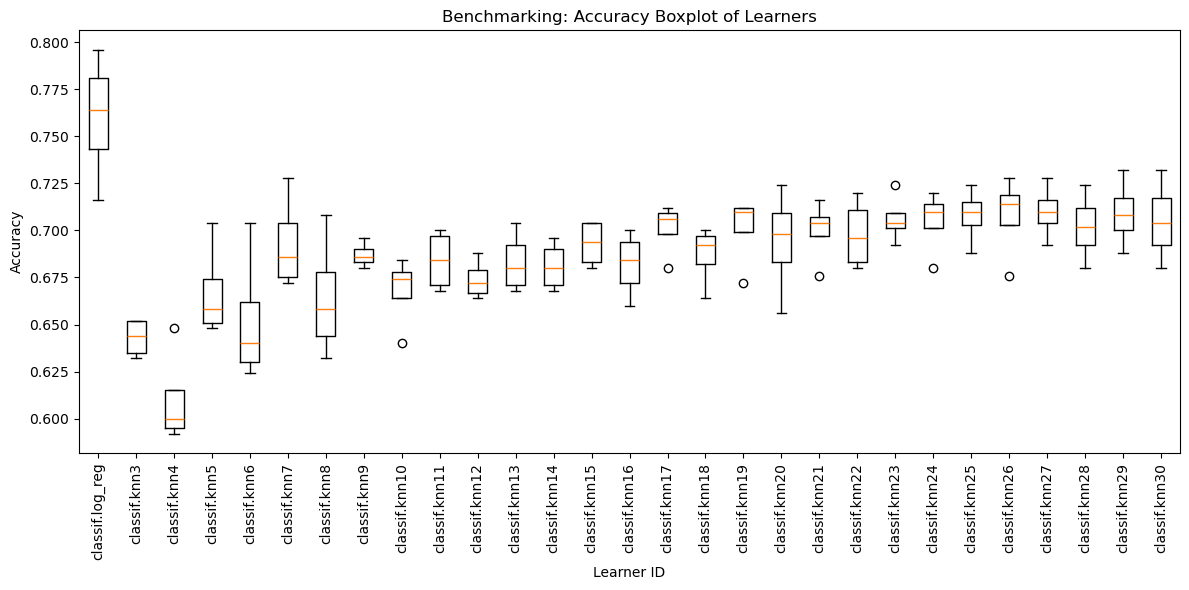

In [6]:
#===SOLUTION===

import matplotlib.pyplot as plt


# Create a boxplot for each learner's accuracy scores.
plt.figure(figsize=(12, 6))
plt.boxplot(list(accuracy_scores.values()))
plt.xticks(ticks=range(1, len(accuracy_scores) + 1), labels=list(accuracy_scores.keys()), rotation=90)
plt.xlabel('Learner ID')
plt.ylabel('Accuracy')
plt.title('Benchmarking: Accuracy Boxplot of Learners')
plt.tight_layout()
plt.show()

## Interpret the results

Interpret the plot. Which 𝑘 seems to work well given the task? Would you prefer a logistic regression over a KNN learner?

===SOLUTION===

Solution:
In this Python solution, logistic regression outperforms the KNN learners. The best $k$ is around 19. If the $k$ is too small, then the KNN underfits. However, in this benchmark, we did not observe the similar phenomenon as in the R solution that $k > 20$ leads to a large variance of accuracy. This descrepancy may come from the encoding strategy for the categorical features is different in our solution and `mlr3`. In this solution, we use `pd.get_dummies` to create one-hot encoded features. Additionally, the descrepancy can also stem from the implementations of k-NN in `scikit-learn` and `mlr3`.

## Extra: Parallelize your efforts

We use sklearn's built-in parallelism to parallelize the benchmark.

<details>
<summary>Hint 1:</summary>
Set the `n_jobs` parameter of the `cross_validate` function to a number greater than 1 to parallelize the benchmarking.
</details>

<details>
<summary>Hint 2:</summary>
Use `StandardScaler` to standardize the continuous features before running the benchmark. Otherwise, sklearn will throw a `ConvergenceWarning`.
We have already recorded the continuous columns' indices in the `continuous_cols` variable.
</details>

In [7]:
#===SOLUTION===

from sklearn.preprocessing import StandardScaler

# Standardize continuous features, otherwise sklearn will throw ConvergenceWarning.
X[continuous_cols] = StandardScaler().fit_transform(X[continuous_cols])

learners = create_learners()  # Now returns a dict of name -> learner object

# We define a function to run cross-validation for a single learner.
def run_learner(learner_id, model):
    cv_results = cross_validate(model, X, y, cv=cv,
                    scoring={'accuracy': 'accuracy', 'fpr': fpr_scorer},
                    n_jobs=4)
    acc_mean = np.mean(cv_results['test_accuracy'])
    fpr_mean = np.mean(cv_results['test_fpr'])
    return learner_id, cv_results['test_accuracy'], acc_mean, fpr_mean

parallel_results = [run_learner(learner_id, model) for learner_id, model in learners.items()]

# Process results: gather fold-wise accuracy scores and aggregated results.
accuracy_scores = {}
results = []
for learner_id, scores, acc_mean, fpr_mean in parallel_results:
    accuracy_scores[learner_id] = scores
    results.append({'learner_id': learner_id,
                    'classif.acc': acc_mean,
                    'classif.fp': - fpr_mean})

results_df = pd.DataFrame(results)
results_df.head()

,learner_id,classif.acc,classif.fp
0,classif.log_reg,0.758,53.000000
1,classif.knn3,0.707,61.000000
2,classif.knn4,0.678,49.666667
3,classif.knn5,0.722,65.333333
4,classif.knn6,0.704,55.000000
